In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
from utils import Config, plot_epoch

### DATA

class mfcc_set(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        data = self.X[index:index+1]
        # remove dimension 0
        data = data.squeeze(0)
        label = self.y[index]
        return torch.Tensor(data), torch.Tensor(label).type(torch.LongTensor)
    
 

In [22]:
hidden_size = 128
### MODEL
class Model(nn.Module):
    '''Model structure
    :input: (batch_size, len_seq, num_feature)
    
    => RNN hidden_state: (2, batch_size, 100)
    => Linear(softmax)
    
    :output: (batch_size, 1, output_size=3)
    '''
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        ## GRU with two layer of hidden layer
        self.rnn = nn.GRU(self.input_size, self.hidden_size, num_layers=4, dropout=0.3, batch_first=True).to(self.device)
        ## batch normalization
        # self.batch = nn.BatchNorm1d(801)
        # self.rnn2 = nn.GRU(self.input_size, self.hidden_size, num_layers=2, dropout=0.3, batch_first=True).to(self.device)
        ## full connected layer
        self.fc = nn.Linear(self.hidden_size, self.output_size).to(self.device)
       
        
    # create function to init state
    def init_hidden(self, batch_size):
        return torch.zeros(4, batch_size, self.hidden_size)
    
    def forward(self, x):     
        batch_size = x.size(0)
        h = self.init_hidden(batch_size).to(self.device)
        out, h_out = self.rnn(x, h)
        h_out = h_out.to(self.device)
        # out = self.batch(out)
        # out, h_out = self.rnn2(out,h_out)
        out = self.fc(out)
        out = out.to(self.device)
        
        #return out, h
        return out
        

## Train

In [3]:
import numpy as np
import h5py
from utils import Config, plot_epoch
import os.path as osp
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import time
import copy

DEBUG = False
if DEBUG:
    with h5py.File(Config['hw5_data.hdf5'] , 'r') as hf:
        train_data = hf['train_data'][:100]
        train_label = hf['train_label'][:100]

    train_data, valid_data, train_label, valid_label = train_test_split(train_data, train_label, test_size=0.11, random_state=112)
else:
    with h5py.File(Config['hw5_data2.hdf5'] , 'r') as hf:
        train_data = hf['train_data'][:]
        train_label = hf['train_label'][:]
   
    train_data, valid_data, train_label, valid_label = train_test_split(train_data, train_label, test_size=0.11, random_state=112)


In [4]:
print("train data type:", train_data.shape)
print("valid data type:", valid_data.shape)
# print("test data type:", test_data.shape)

train data type: (19817, 801, 64)
valid data type: (2450, 801, 64)


In [34]:
train_dataset = mfcc_set(train_data, train_label)
valid_dataset = mfcc_set(valid_data, valid_label)
# set device
device = torch.device('cuda:0' if torch.cuda.is_available() and Config['use_cuda'] else 'cpu')
# set dataloaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)

# model configuration
learning_rate = 0.001
num_feature = 64
hidden_size = 64

model = Model(input_size=num_feature, hidden_size=hidden_size, output_size=3).to(device)
loss_func = nn.CrossEntropyLoss(weight=torch.Tensor([147, 36, 99])).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma=0.5)



In [35]:
### TRAIN
train_acc = []
valid_acc = []
train_loss_list = []

num_epochs = Config['num_epochs']
model.train()


for epoch in tqdm(range(num_epochs)):
    count_right = 0
    train_loss = 0
    
    for x, y in train_loader:
        
        x = x.to(device)
        y = y[:,-1,:].to(device)
        y = torch.argmax(y, axis=1).to(device)
        yhat = model(x)[:,-1,:].to(device)
        ytrue = y.cpu()
        yres = yhat.cpu()
        optimizer.zero_grad()
        loss = loss_func(yhat, y)
        
        loss.backward()
        optimizer.step()
        # scheduler.step()
        train_loss += loss
        
        with torch.no_grad():
            count_right += torch.sum(torch.argmax(yres, axis=1)==ytrue).double()
    
    print(f'Epoch: {epoch+1:02d}, ' +
          f'Loss: {train_loss / len(train_loader.dataset):.4f}, ' + 
          f'Training ACC: {count_right / len(train_loader.dataset):.3f}')
    train_acc.append(count_right / len(train_loader.dataset))
    train_loss_list.append(train_loss / len(train_loader.dataset))
    curr_valid_acc = 0.0
    best_valid_acc = 0.0
    with torch.no_grad():
        correct = 0.0
        ## using the sequence model
        for x, y in valid_loader:
            x = x.to(device)
            y = y[:,-1,:]
            y = torch.argmax(y, axis=1)
            yhat = model(x)[:,-1,:].cpu()
            
            correct += torch.sum(torch.argmax(yhat, axis=1)==y).double()
        print(f'Epoch: {epoch+1:02d}, Valid ACC in Sequence Model: {correct / len(valid_loader.dataset):.3f}') 
    valid_acc.append(correct / len(valid_loader.dataset))
    curr_valid_acc = correct / len(valid_loader.dataset)
    if best_valid_acc < curr_valid_acc and epoch > Config['num_epochs'] - 10:
        best_valid_acc = curr_valid_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, osp.join(Config['root_path'], Config['checkpoint_path'], 'gru3.pth'))

print('Finished Training')







  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 01, Loss: 0.0059, Training ACC: 0.539








  4%|▍         | 1/25 [02:25<58:21, 145.91s/it]

Epoch: 01, Valid ACC in Sequence Model: 0.614
Epoch: 02, Loss: 0.0041, Training ACC: 0.709








  8%|▊         | 2/25 [04:51<55:54, 145.83s/it]

Epoch: 02, Valid ACC in Sequence Model: 0.768
Epoch: 03, Loss: 0.0029, Training ACC: 0.793








 12%|█▏        | 3/25 [07:17<53:30, 145.92s/it]

Epoch: 03, Valid ACC in Sequence Model: 0.817
Epoch: 04, Loss: 0.0022, Training ACC: 0.837








 16%|█▌        | 4/25 [09:44<51:06, 146.04s/it]

Epoch: 04, Valid ACC in Sequence Model: 0.845
Epoch: 05, Loss: 0.0018, Training ACC: 0.870








 20%|██        | 5/25 [12:10<48:42, 146.11s/it]

Epoch: 05, Valid ACC in Sequence Model: 0.851
Epoch: 06, Loss: 0.0015, Training ACC: 0.887








 24%|██▍       | 6/25 [14:35<46:13, 145.98s/it]

Epoch: 06, Valid ACC in Sequence Model: 0.869
Epoch: 07, Loss: 0.0013, Training ACC: 0.901








 28%|██▊       | 7/25 [17:01<43:47, 145.98s/it]

Epoch: 07, Valid ACC in Sequence Model: 0.881
Epoch: 08, Loss: 0.0011, Training ACC: 0.918








 32%|███▏      | 8/25 [19:27<41:20, 145.93s/it]

Epoch: 08, Valid ACC in Sequence Model: 0.896
Epoch: 09, Loss: 0.0009, Training ACC: 0.928








 36%|███▌      | 9/25 [21:53<38:55, 145.96s/it]

Epoch: 09, Valid ACC in Sequence Model: 0.880
Epoch: 10, Loss: 0.0008, Training ACC: 0.936








 40%|████      | 10/25 [24:20<36:31, 146.12s/it]

Epoch: 10, Valid ACC in Sequence Model: 0.919
Epoch: 11, Loss: 0.0008, Training ACC: 0.936








 44%|████▍     | 11/25 [26:46<34:06, 146.16s/it]

Epoch: 11, Valid ACC in Sequence Model: 0.908
Epoch: 12, Loss: 0.0007, Training ACC: 0.951








 48%|████▊     | 12/25 [29:13<31:41, 146.30s/it]

Epoch: 12, Valid ACC in Sequence Model: 0.916
Epoch: 13, Loss: 0.0006, Training ACC: 0.956








 52%|█████▏    | 13/25 [31:39<29:14, 146.19s/it]

Epoch: 13, Valid ACC in Sequence Model: 0.925
Epoch: 14, Loss: 0.0005, Training ACC: 0.959








 56%|█████▌    | 14/25 [34:05<26:50, 146.37s/it]

Epoch: 14, Valid ACC in Sequence Model: 0.918
Epoch: 15, Loss: 0.0006, Training ACC: 0.954








 60%|██████    | 15/25 [36:30<24:18, 145.83s/it]

Epoch: 15, Valid ACC in Sequence Model: 0.917
Epoch: 16, Loss: 0.0005, Training ACC: 0.961








 64%|██████▍   | 16/25 [38:55<21:50, 145.56s/it]

Epoch: 16, Valid ACC in Sequence Model: 0.933
Epoch: 17, Loss: 0.0005, Training ACC: 0.961








 68%|██████▊   | 17/25 [41:20<19:24, 145.55s/it]

Epoch: 17, Valid ACC in Sequence Model: 0.935
Epoch: 18, Loss: 0.0005, Training ACC: 0.962








 72%|███████▏  | 18/25 [43:47<17:01, 145.88s/it]

Epoch: 18, Valid ACC in Sequence Model: 0.931
Epoch: 19, Loss: 0.0005, Training ACC: 0.966








 76%|███████▌  | 19/25 [46:18<14:43, 147.26s/it]

Epoch: 19, Valid ACC in Sequence Model: 0.932
Epoch: 20, Loss: 0.0004, Training ACC: 0.969








 80%|████████  | 20/25 [48:46<12:18, 147.73s/it]

Epoch: 20, Valid ACC in Sequence Model: 0.929
Epoch: 21, Loss: 0.0003, Training ACC: 0.975








 84%|████████▍ | 21/25 [51:11<09:47, 146.86s/it]

Epoch: 21, Valid ACC in Sequence Model: 0.924
Epoch: 22, Loss: 0.0004, Training ACC: 0.974








 88%|████████▊ | 22/25 [53:36<07:18, 146.19s/it]

Epoch: 22, Valid ACC in Sequence Model: 0.926
Epoch: 23, Loss: 0.0004, Training ACC: 0.973








 92%|█████████▏| 23/25 [56:01<04:51, 145.82s/it]

Epoch: 23, Valid ACC in Sequence Model: 0.930
Epoch: 24, Loss: 0.0003, Training ACC: 0.978








 96%|█████████▌| 24/25 [58:26<02:25, 145.53s/it]

Epoch: 24, Valid ACC in Sequence Model: 0.933
Epoch: 25, Loss: 0.0004, Training ACC: 0.973








100%|██████████| 25/25 [1:00:50<00:00, 146.04s/it]

Epoch: 25, Valid ACC in Sequence Model: 0.941
Finished Training


In [36]:
import matplotlib.pyplot as plt
def plot_epoch(x_list, y_list, fname, num_epochs=Config['num_epochs'], accuracy="Accuracy"):
    l = [i for i in range(1, len(x_list)+1)]
    new_ticks=np.linspace(0,num_epochs,6)
    plt.plot(l, x_list,label="Training set")
    plt.plot(l, y_list,label="Validation set")

    plt.xticks(new_ticks)
    plt.title(f"{accuracy} Performance Versus Epoch")
    plt.legend(labels=["Training set", "Validation set"],loc='best')
    plt.xlabel("Epoches")
    plt.ylabel(accuracy)
    plt.show()
#     plt.savefig(fname=fname)
#     plt.close()
    return 

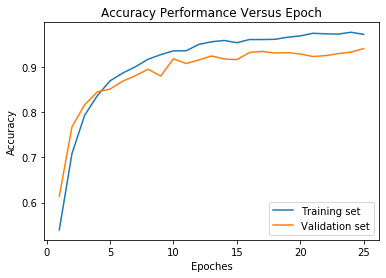

In [37]:
plot_epoch(train_acc, valid_acc, "GRU_sequence_model.jpg")

In [38]:
def plot_epoch_loss(x_list, fname, num_epochs=Config['num_epochs'], accuracy="Loss"):
    l = [i for i in range(1, len(x_list)+1)]
    new_ticks=np.linspace(0,num_epochs,6)
    plt.plot(l, x_list,label="Training Loss")

    plt.xticks(new_ticks)
    plt.title(f"{accuracy} Performance Versus Epoch")
    plt.xlabel("Epoches")
    plt.ylabel(accuracy)
    plt.show()
#     plt.savefig(fname=fname)
#     plt.close()
    return 

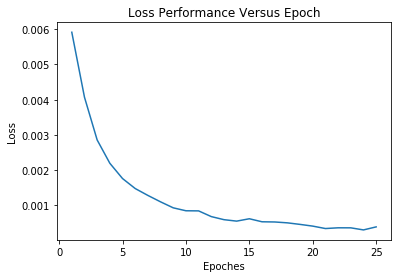

In [39]:
plot_epoch_loss(train_loss_list,fname="GRU_sequence_loss")